Convolution Neural Network Practice

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

%matplotlib inline

plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

Padding

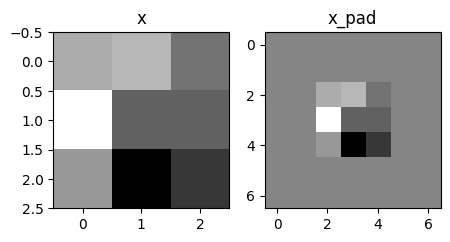

In [2]:
def zero_pad(X, pad):
    X_pad = np.pad(X, ((0,0), (pad, pad), (pad, pad), (0, 0)), mode='constant', constant_values = (0, 0))
    return X_pad

np.random.seed(42)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 2)

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])

axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])


Single step of convolution

In [3]:
def conv_single_step(a_slice_prev, W, b):
    s = np.multiply(a_slice_prev, W)
    Z = np.sum(s)
    Z = Z + float(b)
    return Z

np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)

/tmp/ipykernel_980/1935208622.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z = Z + float(b)


Convolution layer Forward Pass

In [4]:
def conv_forward(A_prev, W, b, hparameters):
    # dont quite understand where did this m come from
    # I thought we were loading 3D images
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape[0], A_prev.shape[1], A_prev.shape[2], A_prev.shape[3]
    (f, f, n_C_prev, n_C) = W.shape[0], W.shape[1], W.shape[2], W.shape[3]
    pad, stride = hyper_params['pad'], hyper_params['stride']

    n_H = int((n_H_prev + 2*pad - f) / stride + 1)
    n_W = int((n_W_prev + 2*pad - f) / stride + 1)
    Z = np.zeros([m, n_H, n_W, n_C]) #seems like I can do random as well, it wont matter
    A_prev_pad = zero_pad(A_prev, pad)

    for i in range(m): #loops through all the m examples
        a_prev_pad = A_prev_pad[i] # maybe we are just adding all the input images in one thats why this bitch is 4D
        for h in range(n_H):
            vert_start = stride * h
            vert_end = vert_start + f

            for w in range(n_W):
                horiz_start = stride * w
                horiz_end = horiz_start + f

                for c in range(n_C):
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                    weights = W[:,:,:,c] # just takes the filter values for each channel one by one
                    biases = b[:,:,:,c] # same as above
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, weights, biases)

    assert(Z.shape == (m, n_H, n_W, n_C))
    cache = (A_prev, W, b, hyper_params)

    return Z, cache

np.random.seed(1)
A_prev = np.random.randn(10, 5, 7, 4)
W = np.random.randn(3, 3, 4, 8)
b = np.random.randn(1, 1, 1, 8)
hyper_params = { 'pad': 1, 'stride': 2 }


Z, cache_conv = conv_forward(A_prev, W, b, hyper_params)
print(np.mean(Z))

0.6923608807576933


/tmp/ipykernel_980/1935208622.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z = Z + float(b)


Pooling layer forward pass

In [5]:
def pool_forward(A_prev, hyper_params, mode='max'):
    # Gets the number of images in input data and its RGB so this is 4D
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape[0], A_prev.shape[1], A_prev.shape[2], A_prev.shape[3]
    # There are no weight and biases because this is a pooling layer
    # only things needed are filter size and stride
    f = hyper_params['f']
    stride = hyper_params['stride']

    n_H = int((n_H_prev - f)/stride + 1)
    n_W = int((n_W_prev - f)/stride + 1)
    n_C = n_C_prev

    # Initialize the final output array
    A_pool = np.zeros((m, n_H, n_W, n_C))

    for i in range(m):
        for h in range(n_H):
            vert_start = stride * h
            vert_end = vert_start + f
            for w in range(n_W):
                horiz_start = stride * w
                horiz_end = horiz_start + f
                for c in range(n_C):
                    a_prev_slice = A_prev[i]
                    if mode == 'max':
                        A_pool[i, h, w, c] = np.max(a_prev_slice[vert_start:vert_end, horiz_start:horiz_end, c])
                    elif mode == 'avg':
                        A_pool[i, h, w, c] = np.mean(a_prev_slice[vert_start:vert_end, horiz_start:horiz_end, c])

    # Dont understand why are we caching A_prev and not A_pool, A_prev array is unchanged
    cache = (A_prev, hyper_params)
    assert(A_pool.shape == (m, n_H, n_W, n_C)) 

    return A_pool, cache

np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)
hyper_params = { 'stride': 1, 'f': 3 }

A, cache = pool_forward(A_prev, hyper_params, mode='max')

print(A)




[[[[1.74481176 0.90159072 1.65980218]
   [1.74481176 1.46210794 1.65980218]
   [1.74481176 1.6924546  1.65980218]]

  [[1.14472371 0.90159072 2.10025514]
   [1.14472371 0.90159072 1.65980218]
   [1.14472371 1.6924546  1.65980218]]

  [[1.13162939 1.51981682 2.18557541]
   [1.13162939 1.51981682 2.18557541]
   [1.13162939 1.6924546  2.18557541]]]


 [[[1.19891788 0.84616065 0.82797464]
   [0.69803203 0.84616065 1.2245077 ]
   [0.69803203 1.12141771 1.2245077 ]]

  [[1.96710175 0.84616065 1.27375593]
   [1.96710175 0.84616065 1.23616403]
   [1.62765075 1.12141771 1.2245077 ]]

  [[1.96710175 0.86888616 1.27375593]
   [1.96710175 0.86888616 1.23616403]
   [1.62765075 1.12141771 0.79280687]]]]
